# The Plug-and-Chug Notebook for Getting Your Keypoint Moseq syllable-at-a-frame CSV file and Visualizations:
## This notebook includes:
   ### **1. Re-encoding videos**
   ### **2. Creating inferences (label) on your videos using an existing SLEAP model and exporting the coordinates in an .h5 file**
   - you can also do the inferences and exporting the coordinates in the SLEAP application. When running the inferences in the SLEAP app, depending on if and what error message you get, you may need to **re-encode your videos** 
   ### **3. Getting Behavioral Syllables**
   before this step you will have to go to [kpmsmodelmakingtutorial.ipynb](tutorial-notebooks/kpmsmodelmakingtutorial.ipynb) if you do not already have a Keypoint Model trained and the `checkpoint.h5` from that training
   - ##### a. Getting ```results.h5``` from your ```checkpoint.h5```
   - ##### b. Trajectory plots, grid movies, and other visualizations of your behavioral syllables
   - ##### c. ```.csv``` files for analysis



This notebook does not include:
   - how to create and train a SLEAP model
   - how to create and train a Keypoint Moseq model



First, let's get your packages imported so we can use them in our code. A list of packages that you need to install in your environment is in the README.md file. Remember **importing =/= installing** (I've made this silly mistake multiple times when sleep deprived)

In [ ]:
import os
import subprocess #this is how you are going to use FFmpeg. also, installation of the FFmpeg "package" is different from other packages



##### Set up filepaths

In [ ]:
beforereencodingvidfolder_dir = r'C:\Users\Steve\Desktop\steve_sleap_test\beforereencode' #CHANGE HERE to put videos needed to reencode put None if you don't want to reencode
project_dir = r'C:\Users\Steve\Desktop\steve_sleap_test' #CHANGE HERE
sleap_model_path = r'Y:\Karin\tutorialmaking\morekatiesvideosmodeling\sleapstuff\240709_092906.multi_instance.n=1301' #CHANGE HERE where is your SLEAP model?

##### Just setting this up here, but in order for this next cell to work, you need to put your videos (if they are already reencoded or do not need to be reencoded) **in a folder called `videos` within your project directory**
- your `.h5` labels from SLEAP will end up in the `videos` folder. 
- this cell sets the directory of `videos` in your `project_dir` and creates a folder called `videos` if it does not exist.
- if your videos need to be reencoded, just put them in a different folder within your `project_dir` and set your `beforereencodingvidfolder_dir` to that folderpath

In [ ]:
video_dir = os.path.join(project_dir, 'videos')
if not os.path.exists(video_dir):
    os.makedirs(video_dir)

# 1. Re-encoding videos
A common problem with SLEAP are videos that are [not reliably seekable](https://sleap.ai/develop/help.html). In my experience, sometimes when I want to run inferences, SLEAP will print out an error in the error log saying something about an issue with the last frame of the video. I've had this issue with a few videos on the Grid (but somehow not Katie's) and it has to do with how the video data is stored (I'm pretty sure). I have also had issues using Keypoint Moseq where it tells me there is some trouble with a given frame in a video. One of the things you can to trouble shoot is re-encoding. Something to note is that re-encoding ***changes your file***, and 

Anyways, here is a function that will reencode your videos in the ```beforereencodingvidfolder_dir``` folder directory and put them in your `video_dir`

You need to run this code in an environment with os and subprocess.


In [ ]:
def reencode_videos(beforereencodingvidfolder_dir, video_dir):
    if beforereencodingvidfolder_dir is None or not os.path.exists(beforereencodingvidfolder_dir):
        print('no reencoding today!')
        return
    else:
        # Ensure output directory exists
        os.makedirs(video_dir, exist_ok=True)

        # FFmpeg command template
        ffmpeg_command = 'ffmpeg -y -i "{input_file}" -c:v libx264 -pix_fmt yuv420p -preset superfast -crf 23 "{output_file}"'

        # Iterate through each file in beforevidfolder_dir
        for filename in os.listdir(beforereencodingvidfolder_dir):
            input_file = os.path.join(beforereencodingvidfolder_dir, filename)
            output_file = os.path.join(video_dir, filename)
            
            # Construct and execute FFmpeg command
            command = ffmpeg_command.format(input_file=input_file, output_file=output_file)
            
            try:
                subprocess.run(command, shell=True, check=True)
                print(f'Reencoded {filename} and saved as {os.path.basename(output_file)}')
            except subprocess.CalledProcessError as e:
                print(f'Error reencoding {filename}: {e}')

Here is the code to execute said function

In [ ]:
reencode_videos(beforereencodingvidfolder_dir, video_dir)


# 2. Creating inferences (A.K.A. labeling) on your videos using an existing SLEAP model and exporting the 2D coordinates in an .h5 file
At this point you are going to have to change the kernel to "sleap" (whomp whomp) because for some reason I can't do it for you. Believe me, I tried for like an hour. Basically, I couldn't install Keypoint Moseq in the same environment as SLEAP which is why you need to change kernels.

*Anyways*... I wrote a few lines that will run in the terminal to basically generate labels in an .slp file (SLEAP file) and an .h5 file based off of the model that you set 'sleap_model_path' to earlier. The .h5 file is what you will use for classifying the behaviors in your videos. 

You change kernels by clicking "select kernel" in the top right corner 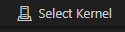 and you will get a drop down menu on the top-middle part of the ribbon. Select the one named "sleap" (or the one with the sleap library in it).
##### TLDR: If you started running this notebook in a different kernel, now is the time to ***change your kernel to sleap***. Also, since changing kernels will reset your variables, ***re-run the cell where you imported your packages and the cell where you specified your file/folder paths***



So this first cell is for SLEAP labeling your videos and producing a .slp file for every video to be labeled (yes it will take awhile)

This will create a folder named `slp_files` within your project directory

In [ ]:
slp_output_dir = os.path.join(project_dir, 'slp_files') 
if not os.path.exists(slp_output_dir): # Create 'slp files' directory if it does not exist
    os.makedirs(slp_output_dir)

In [ ]:
max_tracks = 1 #number of animals you are tracking
tracker = 'simplemaxtracks'
for filename in os.listdir(video_dir):
    if filename.endswith('.mp4'):
        input_file = os.path.join(video_dir, filename)
        output_filename = os.path.splitext(filename)[0] + '.slp'
        output_file_path = os.path.join(slp_output_dir, output_filename)
        sleap_track_command = f"sleap-track -m {sleap_model_path} " \
                              f"--tracking.tracker {tracker} " \
                              f"--tracking.max_tracking {1} " \
                              f"--tracking.max_tracks {max_tracks} " \
                              f"-o {output_file_path} " \
                              f"{input_file}"
        try:
                # Execute the command
                subprocess.run(sleap_track_command, shell=True, check=True)
                print(f'labeled {filename} and saved as {output_filename}')
        except subprocess.CalledProcessError as e:
            print(f'Error processing {filename}: {e}')


This next cell will convert the .slp files to .h5 files

In [ ]:
for filename in os.listdir(slp_output_dir):
    if filename.endswith('.slp'):
        input_slpfile = os.path.join(slp_output_dir, filename)
        output_h5filename = os.path.splitext(filename)[0] + '.h5'
        output_h5file_path = os.path.join(video_dir, output_h5filename)
        sleap_convert_command = f"sleap-convert --format analysis -o {output_h5file_path} {input_slpfile}"
        try:
            subprocess.run(sleap_convert_command)
        except subprocess.CalledProcessError as e:
            print(f'Error processing {filename}: {e}')

# 3. Getting Behavioral Syllables
By this point, you should have either a Keypoint Moseq model ready or have trained a Keypoint Moseq model in the [kpmsmodelmakingtutorial.ipynb](tutorial-notebooks/kpmsmodelmakingtutorial.ipynb)

You have to change your kernel again (whomp whomp) to the one with the keypoint moseq library installed. This means you will also have to run your filepaths again (from the cell at the beginning) and import your packages (from the cell below)

In [ ]:
import os
import subprocess #this is how you are going to use FFmpeg. also, installation of the FFmpeg "package" is different from other packages
import keypoint_moseq as kpms

In [ ]:
kpmsmodel_name = 'my_kappa_scanfull550-100.0' #CHANGE HERE what is the name of your keypoint moseq model? (not the file path)

This will just list all of the .h5 files in your `project_dir/videos/` folder
- in the online [Keypoint Moseq Colab notebook](https://colab.research.google.com/github/dattalab/keypoint-moseq/blob/main/docs/keypoint_moseq_colab.ipynb) from the developers, they have the `videos` folder also have the .h5 labels as well so that is what I am doing here. 

In [ ]:
for filename in os.listdir(video_dir):
    if filename.endswith('.mp4'):
        print(filename)

##### If you want to print out a list of videos files with the suffix `.mat` so you can make a list to put in to the MATLAB analysis, here you go:

In [ ]:
# Iterate over files in the directory
for filename in os.listdir(video_dir):
    # Check if the file has an .mp4 extension
    if filename.endswith('.mp4'):
        # Remove the .mp4 suffix
        name_without_suffix = filename[:-4]
        # Print the filename without the .mp4 suffix
        print(name_without_suffix+'.mat')

### 3a. Getting results.h5 from your checkpoint.h5
So you do need to save your most recent checkpoint as `results.h5`. This code block will also reindex your syllables. Do not run this cell over an existing `results.h5` that you want to keep. it will rewrite it. 

In [ ]:
# load the most recent model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(project_dir, kpmsmodel_name)


# modify a saved checkpoint so syllables are ordered by frequency
kpms.reindex_syllables_in_checkpoint(project_dir, kpmsmodel_name)

# extract results
results = kpms.extract_results(model, metadata, project_dir, kpmsmodel_name)

##### Also load your keypoints from your .h5 files
Just so they can be used in your visualizations

In [ ]:
# Ensure 'videos' directory within data_dir
keypoint_data_path = os.path.join(project_dir, 'videos')

# Load only files ending with .h5
h5_files = [f for f in os.listdir(keypoint_data_path) if f.endswith('.h5')]

# Assuming kpms.load_keypoints and kpms.format_data are functions provided by a library
coordinates, confidences, bodyparts = kpms.load_keypoints([os.path.join(keypoint_data_path, f) for f in h5_files], 'sleap')


### 3b. Trajectory plots, grid movies, and other visualizations of your behavioral syllables


In [ ]:
results = kpms.load_results(project_dir, kpmsmodel_name)
config = lambda: kpms.load_config(project_dir)

##### Make Trajectory Plots:

In [ ]:
kpms.generate_trajectory_plots(coordinates, results, project_dir, kpmsmodel_name, min_frequency=.001, **config()) #you can take out the min_frequency argument if you want to do the default, you can change it to a lower number if you want to see more syllables

##### Generate Grid Movies:

In [ ]:
kpms.generate_grid_movies(results, project_dir, kpmsmodel_name, coordinates=coordinates, dot_radius=10, dot_color=(0, 255, 0), min_frequency=.001,overlay_keypoints=True, **config());

##### Create Syllable Dendrogram:

In [ ]:
kpms.plot_similarity_dendrogram(coordinates, results, project_dir, kpmsmodel_name, **config())

### c. .csv files for analysis

If you want to sort your videos by mutant animal and wild-type you can do it here:

In [ ]:
kpms.interactive_group_setting(project_dir, kpmsmodel_name)

##### to get a table that tells you **when an animal is doing a particular syllable at each frame**, you can do that here
also i'm pretty sure when onset is true, that indicates that it is the frame that a behavior starts.

In [ ]:
moseq_df = kpms.compute_moseq_df(project_dir, kpmsmodel_name, smooth_heading=True) 
moseq_df

and now to save it as a .csv file:

In [ ]:
# save moseq_df
save_dir = os.path.join(project_dir, kpmsmodel_name) # directory to save the moseq_df dataframe
moseq_df.to_csv(os.path.join(save_dir, 'moseq_df.csv'), index=False)
print('Saved `moseq_df` dataframe to', save_dir)

In [ ]:
import pandas as pd
import os  # Import the os module to use os.path.join

# Specify the directory where the CSV file is located
save_dir = os.path.join(project_dir, kpmsmodel_name)

# Read the CSV file into a DataFrame
df = pd.read_csv(os.path.join(save_dir, 'moseq_df.csv'))

# Replace False with empty strings
df.replace(False, '', inplace=True)

# Write the modified DataFrame to a new CSV file
df.to_csv(os.path.join(save_dir, 'modifiedmoseqdf.csv'), index=False)

this can give you some information about the syllables i'm pretty sure:

In [ ]:
stats_df = kpms.compute_stats_df(
    project_dir,
    kpmsmodel_name,
    moseq_df, 
    min_frequency=0.005,       # threshold frequency for including a syllable in the dataframe
    groupby=['group', 'name'], # column(s) to group the dataframe by
    fps=30)                    # frame rate of the video from which keypoints were inferred

stats_df

aaaand you can also save it:

In [ ]:
# save stats_df
save_dir = os.path.join(project_dir, kpmsmodel_name)
stats_df.to_csv(os.path.join(save_dir, 'stats_df'), index=False)
print('Saved `stats_df` dataframe to', save_dir)

##### Here is where you will **label your syllables**:

In [ ]:
kpms.label_syllables(project_dir, kpmsmodel_name, moseq_df) 

##### Heatmap to show you **transition frequencies**

In [ ]:
normalize='bigram' # normalization method ("bigram", "rows" or "columns")

trans_mats, usages, groups, syll_include=kpms.generate_transition_matrices(
    project_dir, kpmsmodel_name, normalize=normalize,
    min_frequency=0.005 # minimum syllable frequency to include
)    

kpms.visualize_transition_bigram(
    project_dir, kpmsmodel_name, groups, trans_mats, syll_include, normalize=normalize, 
    show_syllable_names=False )# label syllables by index (False) or index and name (True)

##### Syllable Transition Graph

In [ ]:
# Generate a transition graph for each single group

kpms.plot_transition_graph_group(
    project_dir, kpmsmodel_name, 
    groups, trans_mats, usages, syll_include, 
    layout='circular',        # transition graph layout ("circular" or "spring")
    show_syllable_names=False) # label syllables by index (False) or index and name (True)

##### Generate a difference graph

In [ ]:
# Generate a difference-graph for each pair of groups.

kpms.plot_transition_graph_difference(project_dir, kpmsmodel_name, 
                                      groups, trans_mats, usages, syll_include, 
                                      layout='circular') # transition graph layout ("circular" or "spring")